In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
import os
import sklearn 
import seaborn as sns
model_pred = keras.models.load_model('sky_status_model.h5')

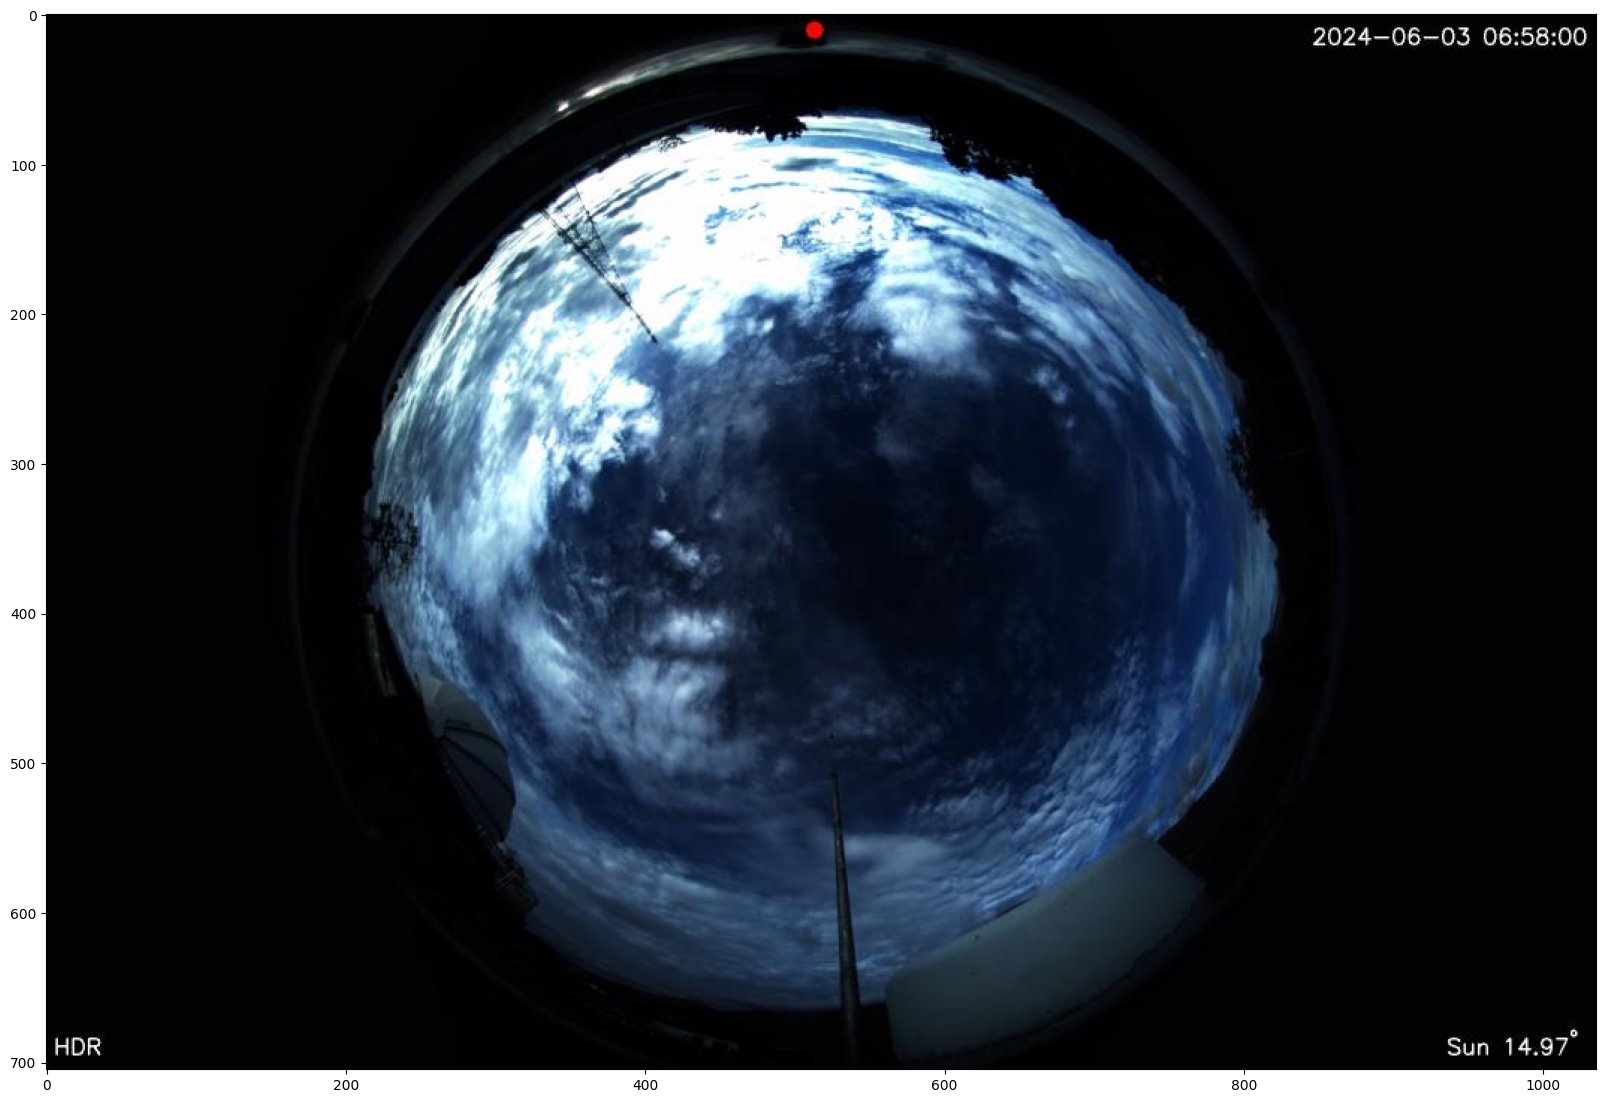

In [3]:
image_path = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-03\638529694930849032.png'
mask_path = r'mask_delete_5.png'

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(cv2.imread(image_path),cv2.COLOR_BGR2RGB)

masked = cv2.bitwise_and(image,image,mask=mask)
plt.figure(figsize=(20,20))
plt.imshow(image)

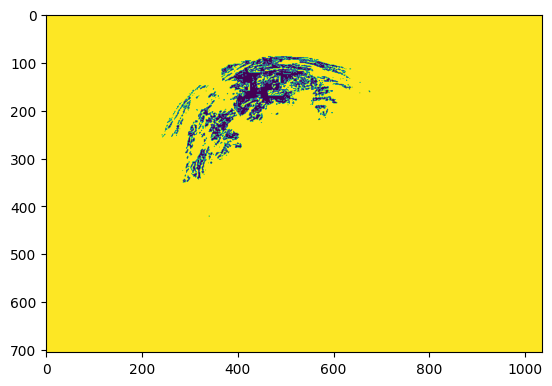

In [4]:
cut = cv2.inRange(masked,np.array([0,0,0]),np.array([254,254,254]))
plt.imshow(cut)

69.54005631362357


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15828\2712184731.py:4: RuntimeWarning: invalid value encountered in divide
  ratio = (R/B)*np.mean(crop_whole)/8


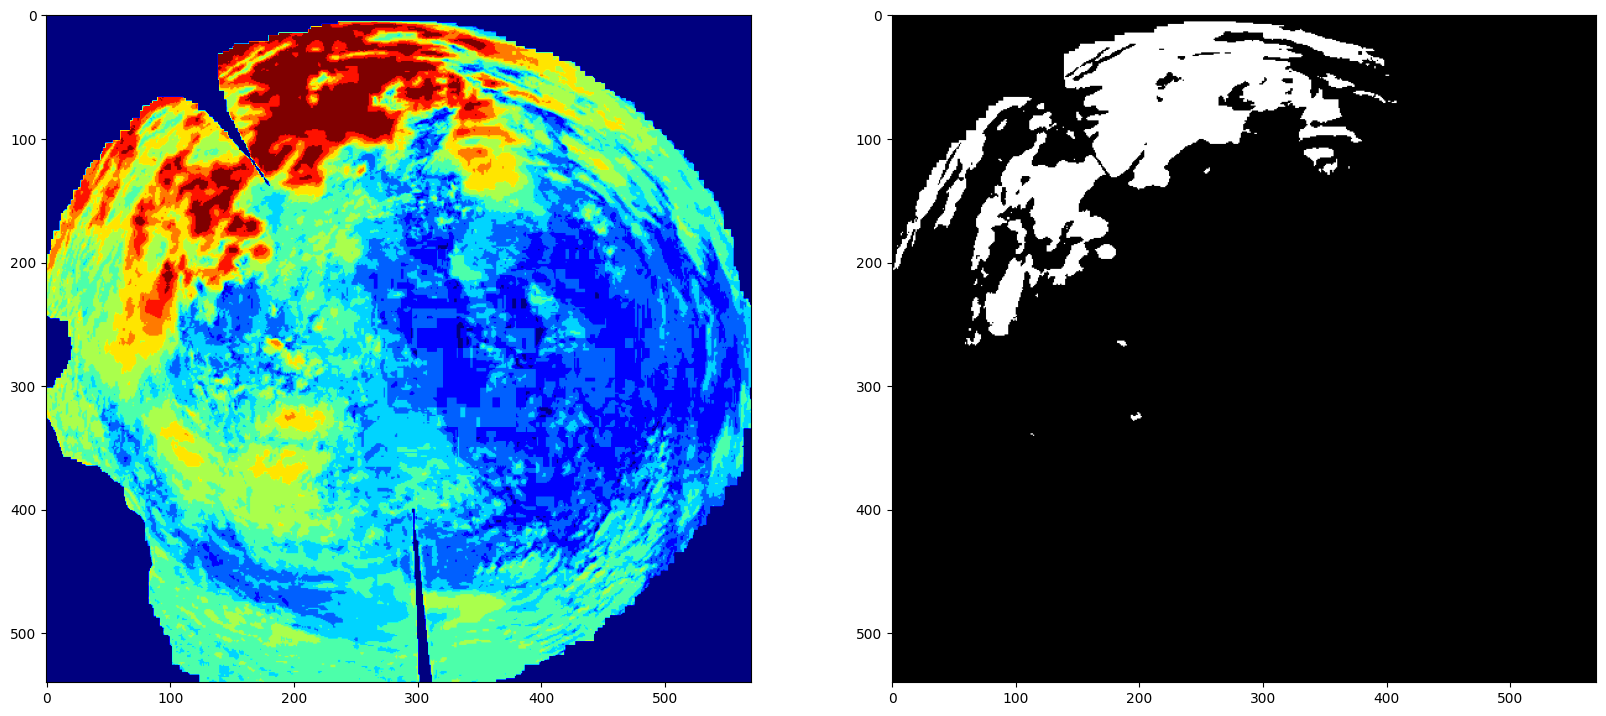

In [5]:
crop_whole = masked[(int(image.shape[0]/2)-270):int((image.shape[0]/2)+270),int((image.shape[1]/2)-290):int((image.shape[1]/2)+280)]
R,G,B = cv2.split(crop_whole)
if np.mean(crop_whole) <= 70:
    ratio = (R/B)*np.mean(crop_whole)/8
    ratio_1 = cv2.convertScaleAbs(ratio)
    _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/10, 255, cv2.THRESH_BINARY)
if np.mean(crop_whole) > 70:
    ratio = (R/B)*np.mean(crop_whole)/10
    ratio_1 = cv2.convertScaleAbs(ratio)
    _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/20, 255, cv2.THRESH_BINARY)
if np.mean(crop_whole) < 45:
    ratio = (R/B)*np.mean(crop_whole)/8
    ratio_1 = cv2.convertScaleAbs(ratio)
    _,final_mask = cv2.threshold(ratio_1, np.mean(crop_whole)/16, 255, cv2.THRESH_BINARY)    

print(np.mean(crop_whole))
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(ratio_1,cmap='jet')
plt.subplot(1,2,2)
plt.imshow(final_mask,cmap='gray')

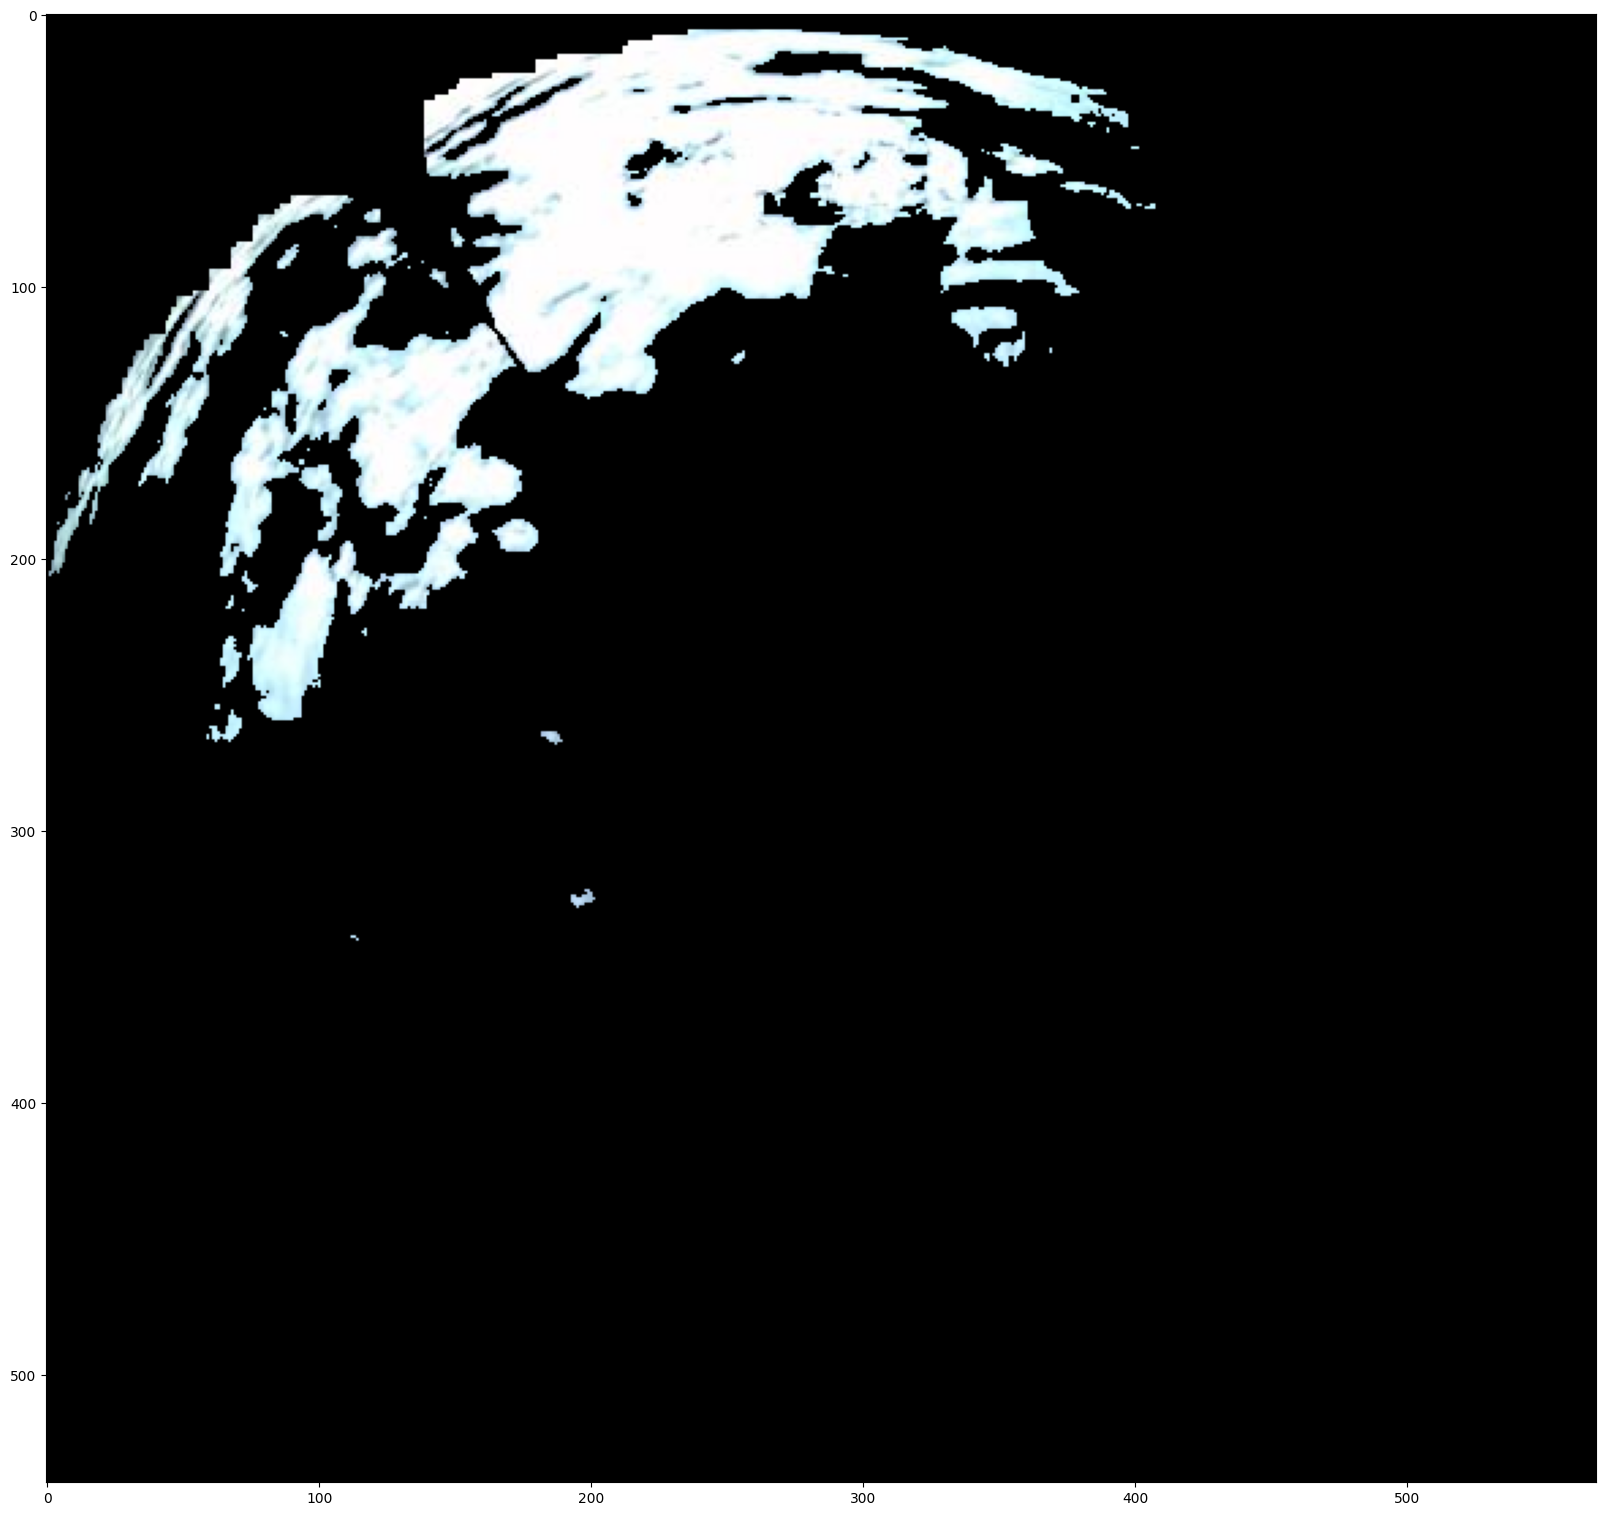

In [6]:
final = cv2.bitwise_and(crop_whole,crop_whole,mask=final_mask)

plt.figure(figsize=(20,20))
plt.imshow(final)

In [7]:
crop_whole = masked[(int(image.shape[0]/2)-270):int((image.shape[0]/2)+270),int((image.shape[1]/2)-290):int((image.shape[1]/2)+280)]
crop_glcm = final

mask_pred = cv2.resize(final,(125,125))
mask_pred = tf.expand_dims(mask_pred, axis=0)

predict_sky = model_pred.predict(mask_pred)[0]
np.asarray(predict_sky)

1/1 [==============================] - 7s 7s/step


array([3.2118493e-08, 5.7951874e-01, 2.6608593e-06, 9.9228549e-01,
       2.8210746e-07], dtype=float32)

In [8]:
cloud_pixel = cv2.countNonZero(cv2.cvtColor(final,cv2.COLOR_RGB2GRAY))
whole = cv2.countNonZero(cv2.cvtColor(masked,cv2.COLOR_RGB2GRAY))

coverage = cloud_pixel/whole

def skyPredict(arg):
    if arg == 1:
        return str("Blue sky")
    if arg == 2:
        return str("Medium cloud")
    if arg == 3:
        return str("Dark cloud")
    if arg == 4:
        return str("White cloud")
    if arg == 5:
        return str("Light cloud")

print(f"cloud percentage :{coverage*100} % , cloud status : {skyPredict(np.argmax(predict_sky)+1)} ")

cloud percentage :11.208396361468552 % , cloud status : White cloud 


In [9]:
from skimage.feature import graycomatrix, graycoprops
from skimage import data

final_gray = cv2.cvtColor(crop_glcm,cv2.COLOR_RGB2GRAY)

distance = [2,3]
angle = [0]

In [10]:
glcm = graycomatrix(final_gray,distances=distance,angles=angle,levels=256)

In [11]:
features = {
        'contrast': graycoprops(glcm, 'contrast').flatten(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').flatten(),
        'homogeneity': graycoprops(glcm, 'homogeneity').flatten(),
        'energy': graycoprops(glcm, 'energy').flatten(),
        'correlation': graycoprops(glcm, 'correlation').flatten(),
        'ASM': graycoprops(glcm, 'ASM').flatten()
    }

Contrast: [ 800.31393127 1164.90660069]
Dissimilarity: [4.21756325 5.81413874]
Homogeneity: [0.93000951 0.92395853]
Energy: [0.90191878 0.89852499]
Correlation: [0.91615043 0.87814173]
Asm: [0.81345748 0.80734716]


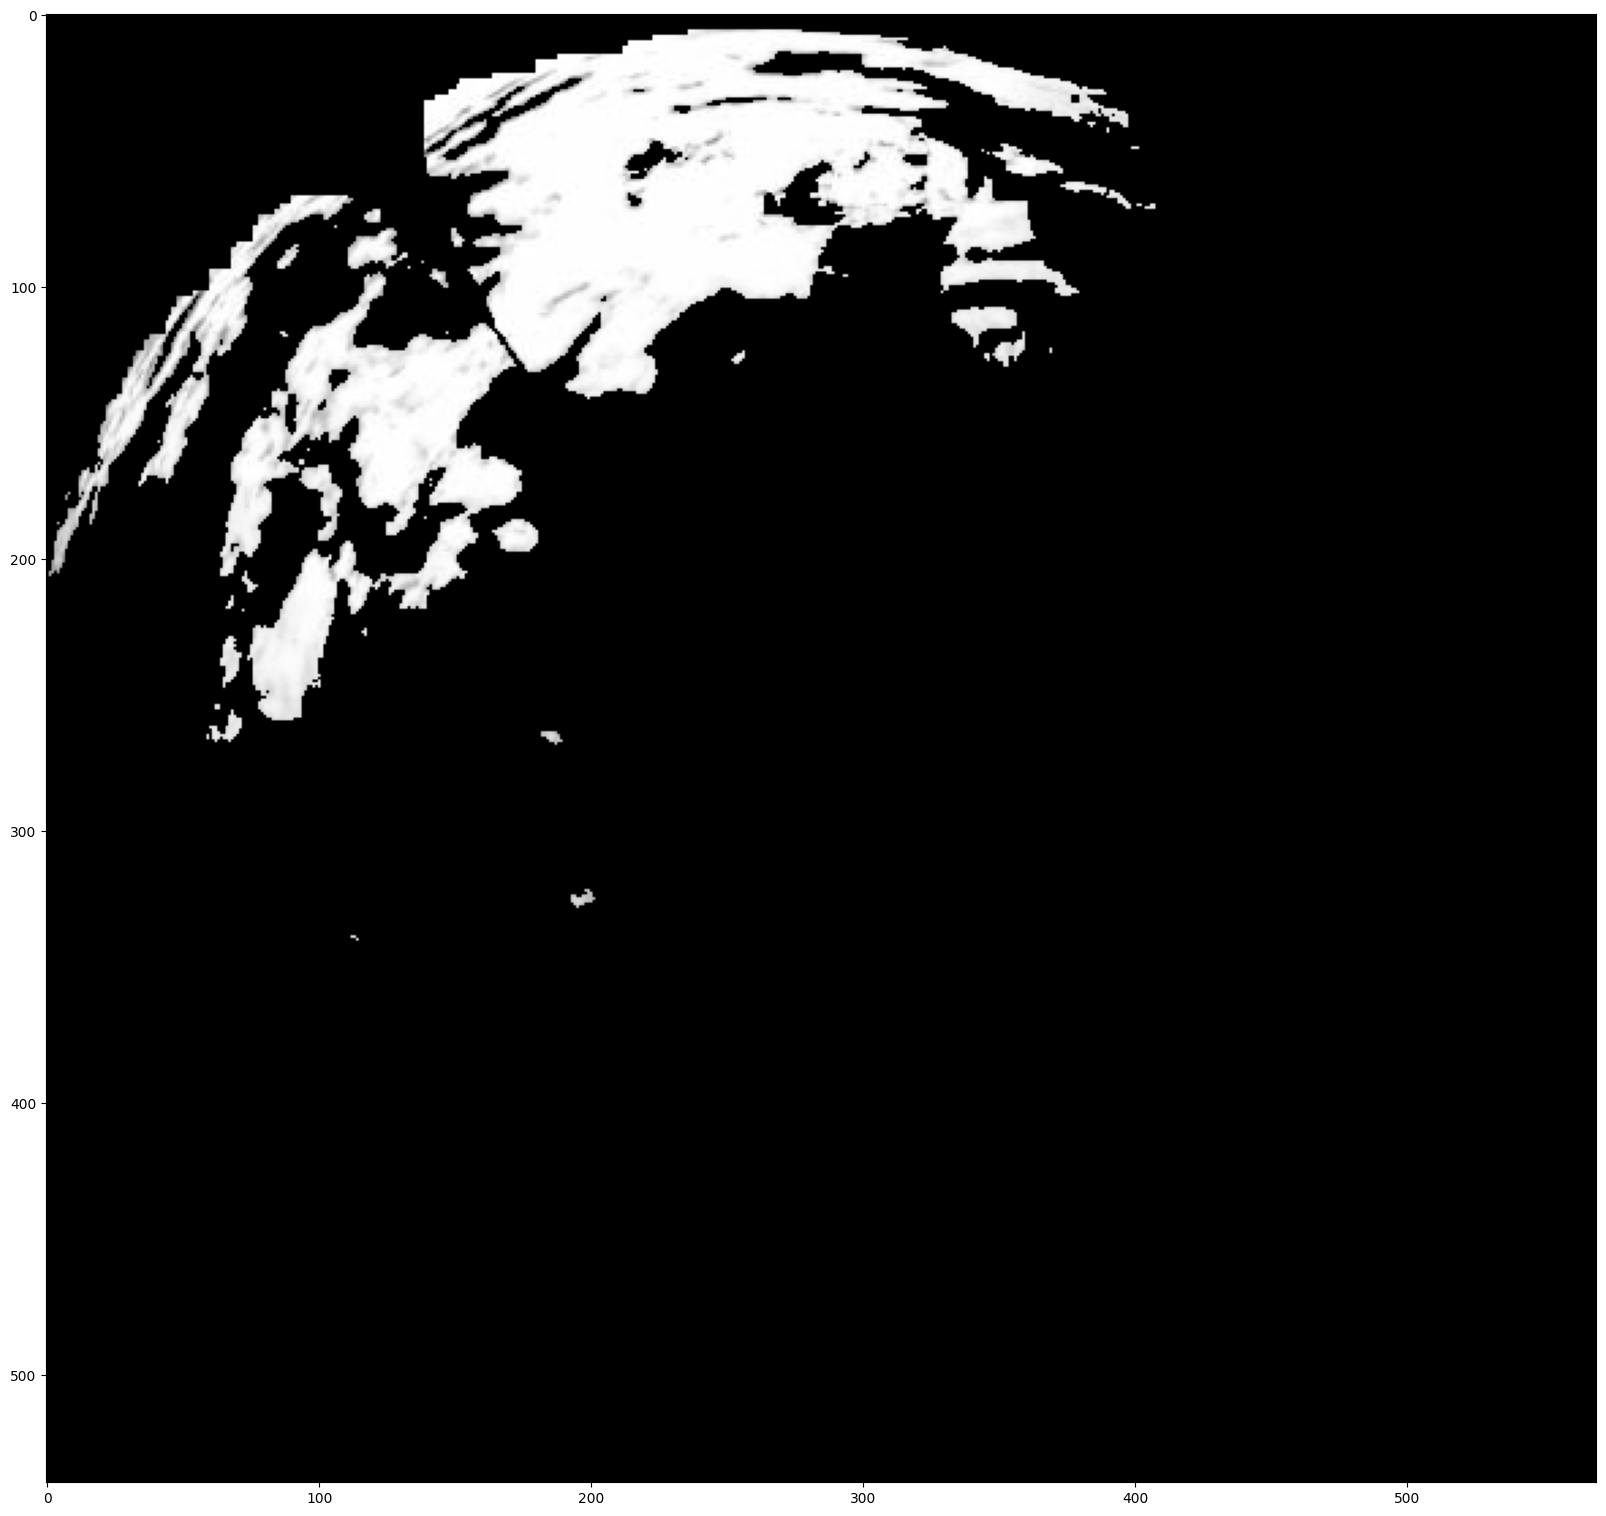

In [12]:
for feature_name, feature_values in features.items():
    print(f"{feature_name.capitalize()}: {feature_values}")

plt.figure(figsize=(20,20))
plt.imshow(final_gray,cmap='gray')


In [13]:
from preprocessing import *
from skimage.feature import graycomatrix,graycoprops

In [14]:
properties = ['contrast',
            'dissimilarity',
            'homogeneity',
            'energy',
            'correlation',
            'ASM']

mask_path = r'C:\Users\ASUS\Documents\NARIT_internship_data\Mask_obs\mask_delete_5.png'
mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
mask = mask[(int(mask.shape[0]/2)-270):int((mask.shape[0]/2)+270),int((mask.shape[1]/2)-290):int((mask.shape[1]/2)+280)]
path = r'All_sky_camera_Astropark_Chaingmai\2024-06\2024-06-28'
images,filename = load_images_and_preprocess(path,mask=mask,apply_crop_sun=True)
masked,value,RB = RBratio(input=images)

In [15]:
glcm = computeGlcm(image=masked,distance=[3],angle=[45])
df = getDataframe(properties,glcm,index=filename,intensity=value,RB=RB)

In [1]:
im = 480
print(value[im])
print("Cloud percentage :",showCloudRatio(masked,mask=mask,number=im)*100,"%")
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(masked[im],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(images[im])

NameError: name 'value' is not defined

: 

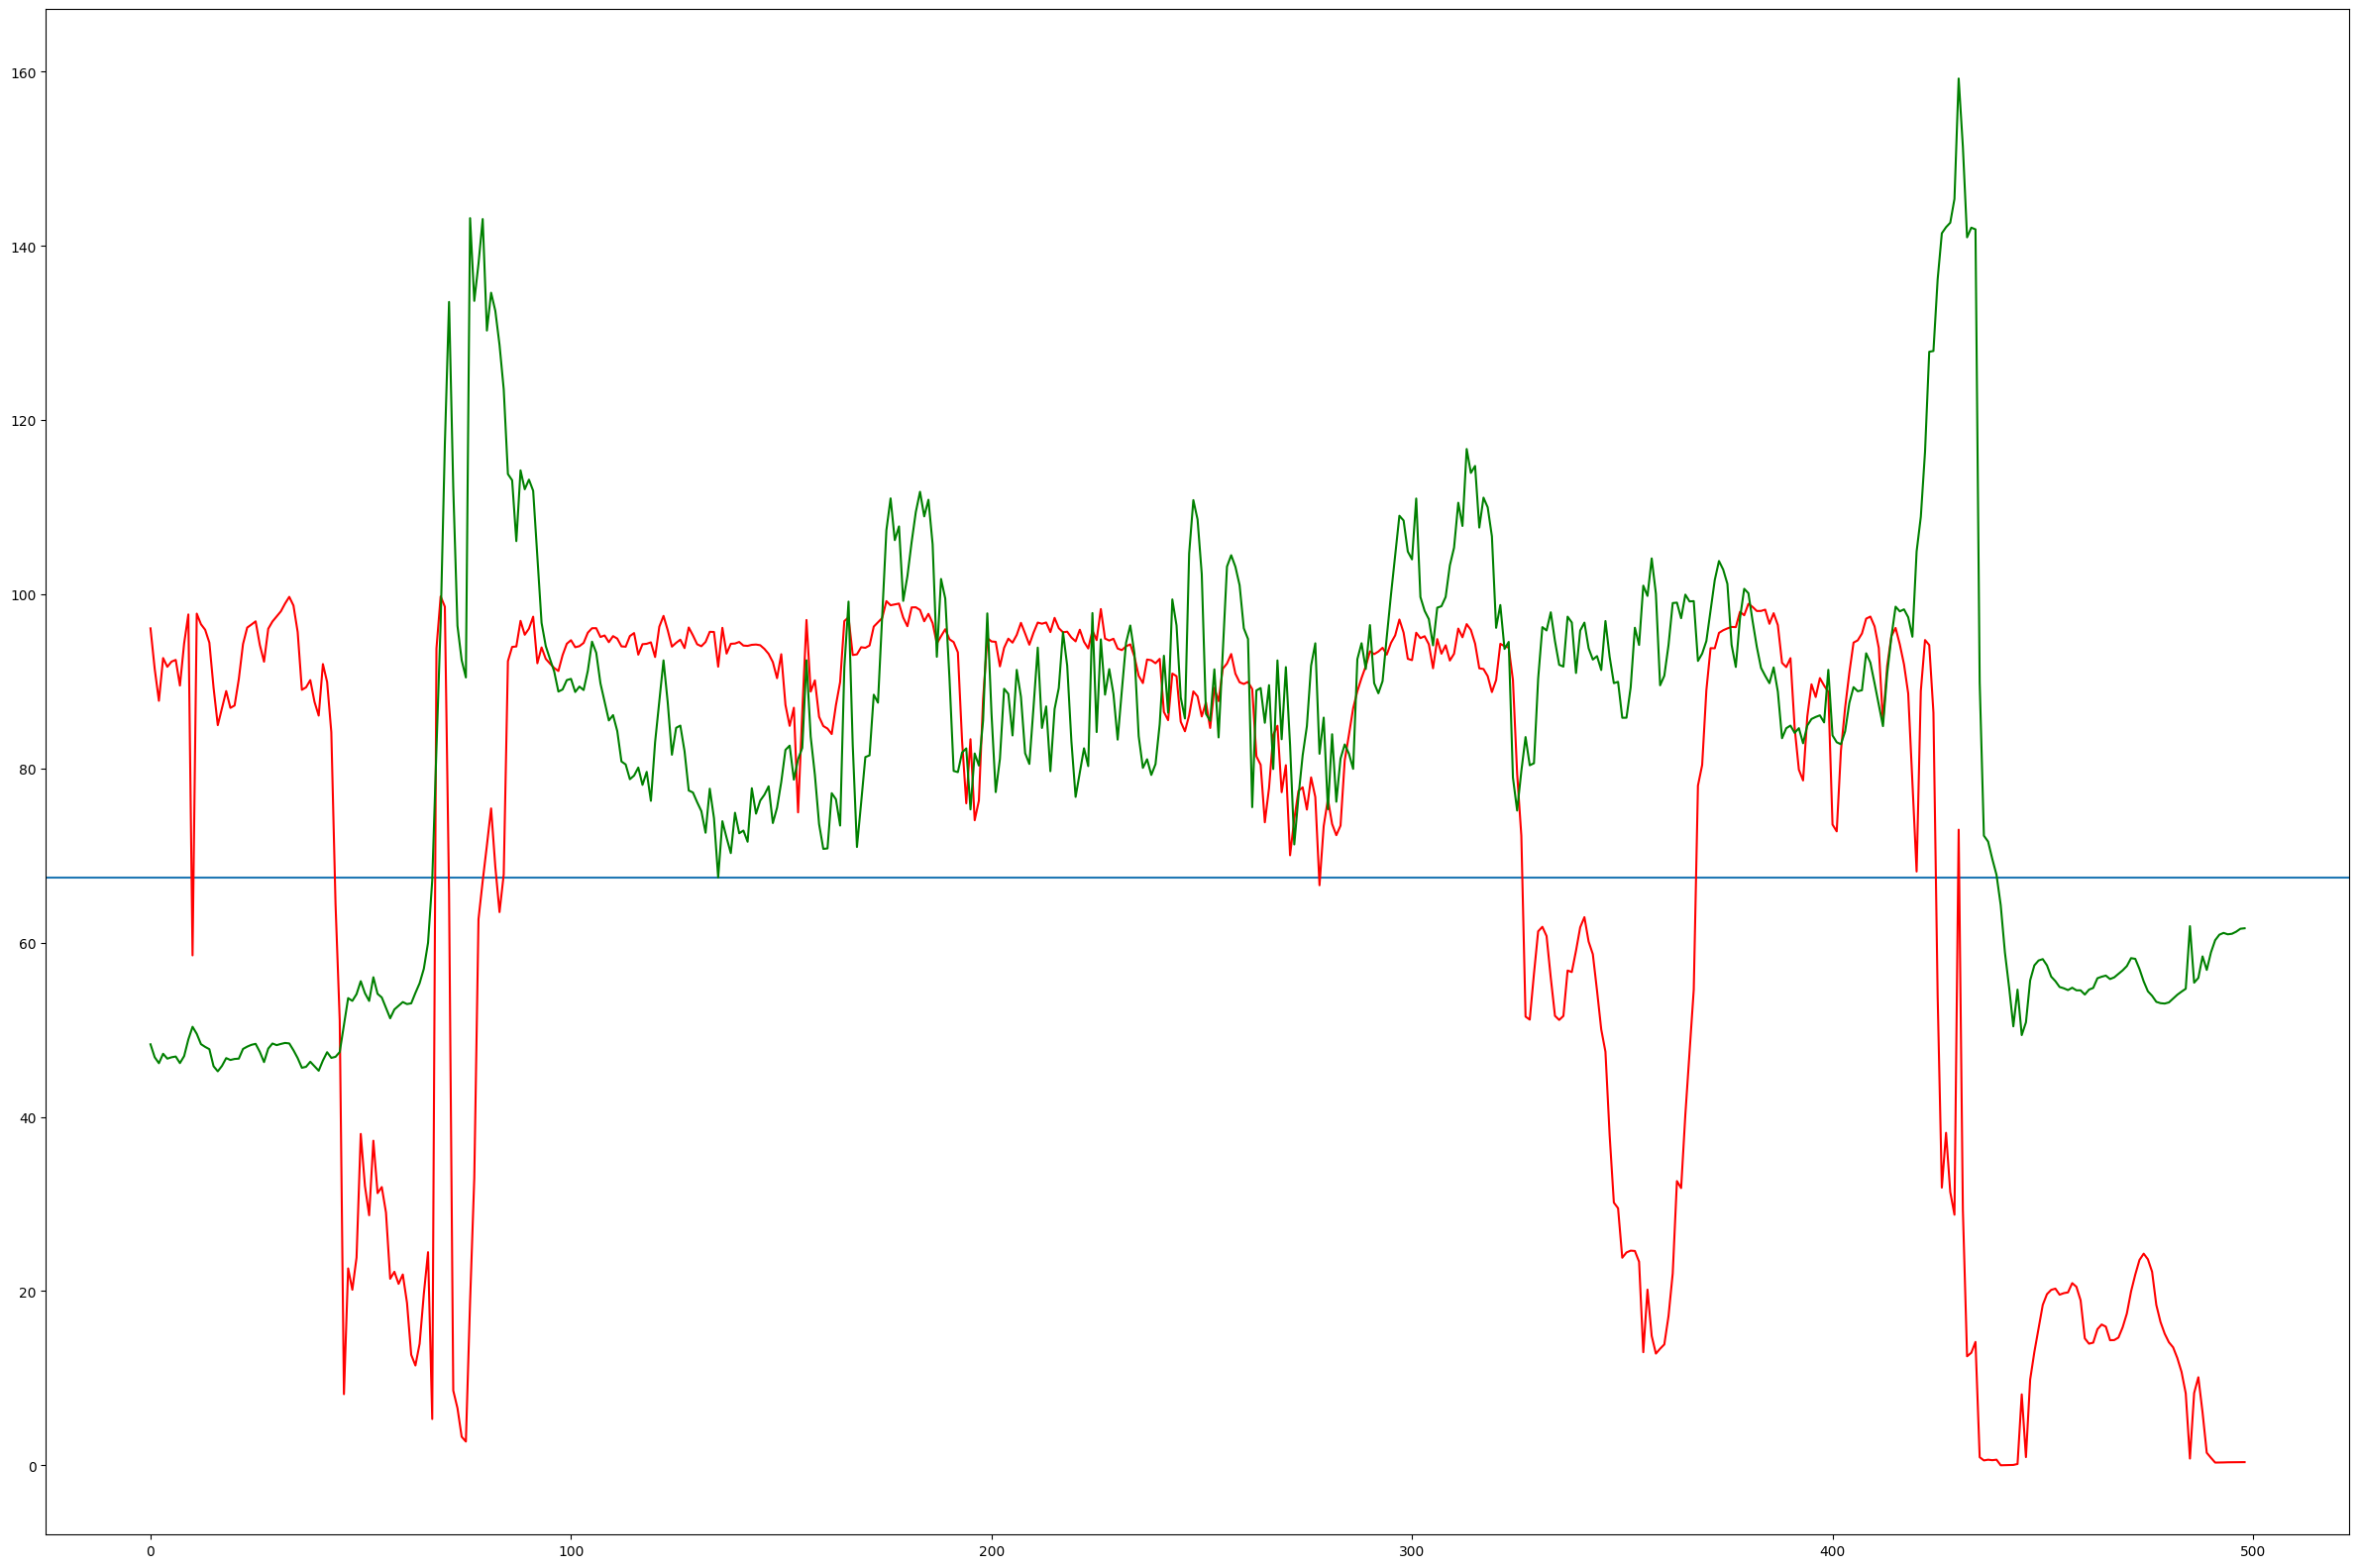

In [17]:
cloud_ratio = []
for r in range(len(masked)):
    cloud_ratio.append(showCloudRatio(masked,mask=mask,number=r)*100)
plt.figure(figsize=(30,20))
plt.axhline(y=Threshold(images))
plt.plot(cloud_ratio,c='r')
plt.plot(df['Blue channel'].values,c='g')

In [18]:
df.to_csv('GLCM_feature_ALL_sky_28June_dis3_ang45_test.csv')


<Axes: >

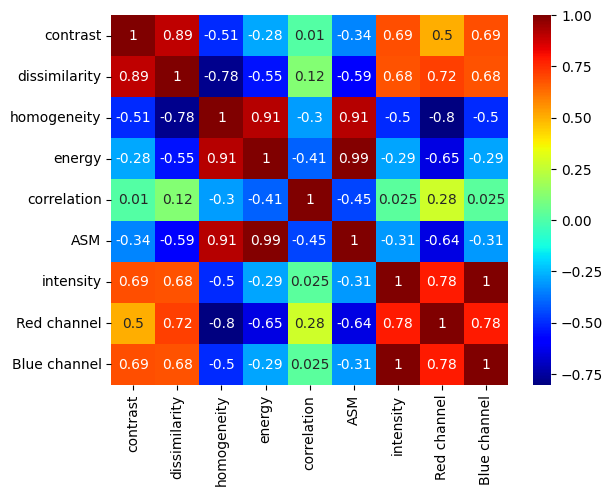

In [19]:
sns.heatmap(df.corr(),annot=True,cmap='jet')

In [20]:
def std(input):
    std = []
    for i in input:
        
        std.append()